# 1. Loading necessary packages

We first need to load several packages that are required to setup and run the model

In [1]:
# main solver
using JustRelax, JustRelax.JustRelax2D, JustRelax.DataIO
# to parallelise helper functions
using ParallelStencil, ParallelStencil.FiniteDifferences2D
# Particles-in-Cell
using JustPIC, JustPIC._2D
# Rheology
using GeoParams
# Visualization
using  CairoMakie

## Setting up the backend

All the code that we will generate is going to be backend agnostic and run on CPUs as well as CUDA or AMDGPUs. However, we always need to choose the backend and dimension of the problem at the beginning of our script.

In [2]:
# Options: CPUBackend, CUDABackend, AMDGPUBackend
# backend of JustRelax
const backend_JR = CPUBackend
# backend of JustPIC
const backend = CPUBackend 
# backend of ParallelStencil
@init_parallel_stencil(Threads, Float64, 2) #or (CUDA, Float64, 2) or (AMDGPU, Float64, 2)

# Model domain and characteristic lengths

With `GeoParams.jl` we can add units to any physical field and also automatically non-dimensionalize anything with a unit attached to it. So we will start by defining the characteristic lengths:

In [3]:
CharDim = GEO_units(;length = 700km, viscosity = 1e20Pas, temperature = 1e3K)

Employing GEO units 
Characteristic values: 
         length:      700 km
         time:        0.3169 Myrs
         stress:      10 MPa
         temperature: 726.85 °C


and now we can define and create the geometry of the problem. Let's do a domain $1400 km \times 700 km$ Cartesian box 

In [4]:
ar           = 1 # aspect ratio
n            = 64 # number of grid cells
nx           = n * ar
ny           = n
ni           = nx, ny
igg          = IGG(init_global_grid(nx, ny, 1)...)
ly           = nondimensionalize(700km, CharDim)  # domain length in y
lx           = ly * ar                            # domain length in x
ni           = nx, ny                             # number of cells
li           = lx, ly                             # domain length in x- and y-
di           = @. li / ni                         # grid step in x- and -y
origin       = 0.0, -ly                           # origin coordinates 
grid         = Geometry(ni, li; origin = origin)
(; xci, xvi) = grid                               # nodes at the center and vertices of the cells

Global grid: 64x64x1 (nprocs: 1, dims: 1x1x1; device support: none)


Geometry{2, Float64}((64, 64), (1.0, 1.0), (0.0, -1.0), 1.0, (0.015625, 0.015625), (LinRange{Float64}(0.0078125, 0.9921875, 64), LinRange{Float64}(-0.9921875, -0.0078125, 64)), (LinRange{Float64}(0.0, 1.0, 65), LinRange{Float64}(-1.0, 0.0, 65)), ((LinRange{Float64}(0.0, 1.0, 65), LinRange{Float64}(-1.0078125, 0.0078125, 66)), (LinRange{Float64}(-0.0078125, 1.0078125, 66), LinRange{Float64}(-1.0, 0.0, 65))))

# 2. Rheology

To keep it simple, we will have only a single dislocation + diffusion creep rheology for the whole domain, but we could have as many as we wanted. We can start by defining the parameters of the creep laws:

In [5]:
disl_lithospheric_mantle    = DislocationCreep(
    A=2.51e-17Pa^(-35//10) / s,
    n=3.5NoUnits, 
    E=530e3J/mol, 
    V=6e-6m^3/mol,  
    r=0.0NoUnits, 
    R=8.3145J/mol/K
)

diff_lithospheric_mantle    = DiffusionCreep(
    A=2.51e-17Pa^(-1) / s,
    n=1.0NoUnits, 
    E=530e3J/mol, 
    V=6e-6m^3/mol,  
    r=0.0NoUnits, 
    p=0.0NoUnits,
    R=8.3145J/mol/K
)

DiffusionCreep: Name = , n=1.0, r=0.0, p=0.0, A=2.51e-17 Pa⁻¹·⁰ s⁻¹·⁰, E=530000.0 J mol⁻¹·⁰, V=6.0e-6 m³·⁰ mol⁻¹·⁰, FT=1.7320508075688772, FE=1.1547005383792517

Next we define a temperature and pressure dependent conductivity

In [6]:
conductivity = TP_Conductivity(;
    a = 0.73Watt / K / m ,
    b = 1293e00Watt / m ,
    c = 0.77K,
    d = 0.00004/ MPa,
)

T/P dependent conductivity: Name = , k = (0.73 + 1293.0/(T + 0.77))*(1 + 4.0e-5*P)  


and we define the rheology data structure that we will pass into the solver:

In [7]:
rheology = (
    SetMaterialParams(;
        Phase             = 1,
        Density           = T_Density(; ρ0=3.3e3kg / m^3, T0=0e0C, α = 3.5e-5/ K),
        HeatCapacity      = ConstantHeatCapacity(; Cp=1.25e3J / kg / K),
        Conductivity      = conductivity,
        CompositeRheology = CompositeRheology((disl_lithospheric_mantle, diff_lithospheric_mantle,)),
        Gravity           = ConstantGravity(; g=9.81m/s^2),
        CharDim           = CharDim,
    ),
    # # NOTE: we could add here more rheology phases by e.g. uncommenting the lines below
    # SetMaterialParams(;
    #     Phase             = 2,
    #     Density           = T_Density(; ρ0=(3.3e3-50)kg / m^3,  T0=0e0C, α = 3.5e-5/ K),
    #     HeatCapacity      = ConstantHeatCapacity(; Cp=1.25e3J / kg / K),
    #     Conductivity      = conductivity,
    #     CompositeRheology = CompositeRheology((disl_sublithospheric_mantle, diff_sublithospheric_mantle,)),
    #     Gravity           = ConstantGravity(; g=9.81m/s^2),
    #     CharDim           = CharDim,
    # ),
)

Phase 1 : 
        | [non-dimensional units]
        | 
        |-- Name              :  
        |-- Density           : Temperature dependent density:  ρ = 1.6170000000000001e-18(1 - 0.034999999999999996(T-0.27315)) 
        |-- Gravity           : Gravitational acceleration: g=1.4014285714285713e21 
        |-- CompositeRheology : --⟦▪̲̅▫̲̅▫̲̅▫̲̅----⟦▪̲̅▫̲̅▫̲̅▫̲̅--
 
        |-- Conductivity      : T/P dependent conductivity: Name = , k = (0.0014897959183673467 + 0.0026387755102040816/(T + 0.0007700000000000001))*(1 + 0.0004*P)  
 
        |-- HeatCapacity      : Constant heat capacity: Cp=2.551020408163265e20 


And define an initial time step

In [8]:
dt = dt_diff = nondimensionalize(10e3 * yr, CharDim)

0.0315576

# 3. Initialize array objects and boundary conditions
### Initialise objects containing the arrays needed for the Stokes and thermal solvers

In [9]:
stokes           = StokesArrays(backend_JR, ni)
thermal          = ThermalArrays(backend_JR, ni)
pt_stokes        = PTStokesCoeffs(li, di; ϵ=1e-7,  CFL = 0.9 / √2.1)

PTStokesCoeffs{Float64}(0.6210590034081188, 1.0e-7, 9.42477796076938, 0.7, 0.009704046928251856, 22.232308736496627, 0.0010296313577513373)

### Define boundary conditions

In [10]:
flow_bcs = VelocityBoundaryConditions(;
    free_slip = (left=true,  right=true,  top=true,  bot=true),
    no_slip   = (left=false, right=false, top=false, bot=false),
)
thermal_bc = TemperatureBoundaryConditions(;
    no_flux = (left = true, right = true, top = false, bot = false),
)

TemperatureBoundaryConditions{@NamedTuple{left::Bool, right::Bool, top::Bool, bot::Bool}, 2}((left = true, right = true, top = false, bot = false))

# 4. Initialize particle objects

In [11]:
nxcell           = 25 # initial number of particles per cell
max_xcell        = 30 # maximum number of particles per cell
min_xcell        = 12 # minimum number of particles per cell
# initialize main particle object
particles        = init_particles(
    backend, nxcell, max_xcell, min_xcell, xvi, di, ni
)
# buffer arrays needed for subgrid diffusion
subgrid_arrays   = SubgridDiffusionCellArrays(particles)
# velocity grids
grid_vx, grid_vy = velocity_grids(xci, xvi, di)
# temperature and material phases on the particles
pT, pPhases      = init_cell_arrays(particles, Val(2))
particle_args    = (pT, pPhases)

(StaticArraysCore.SVector{30, Float64}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] … [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]; [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] … [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]; … ; [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0,

In [12]:
# helper function to define particles material phase
function init_phases!(phases, particles)
    ni = size(phases)
    @parallel_indices (i, j) function init_phases!(phases, index,)
        @inbounds for ip in JustRelax.cellaxes(phases)
            JustRelax.@cell(index[ip, i, j]) == 0 && continue # quick escape
            JustRelax.@cell phases[ip, i, j] = 1.0
        end
        return nothing
    end

    @parallel (@idx ni) init_phases!(phases, particles.index)
end

# initialize phase ratio object
phase_ratios = PhaseRatio(backend_JR, ni, length(rheology))
# define material phases on particles
init_phases!(pPhases, particles)
# material phase at cell centers
phase_ratios_center!(phase_ratios, particles, grid, pPhases)

# 5. Initial conditions
## Thermal profile

In [13]:
function init_T!(thermal, xvi, CharDim)
    ni = size(thermal.T)

    @parallel_indices (i, j) function _init_T!(T, y, CharDim)
        depth = -y[j]

        # (depth - 15e3) because we have 15km of sticky air
        if depth ≤ nondimensionalize(0e0km, CharDim)
            T[i, j] = nondimensionalize(273e0K, CharDim)

        elseif nondimensionalize(0e0km, CharDim) ≤ (depth) < nondimensionalize(35km, CharDim)
            dTdZ    = nondimensionalize((923-273)/35 * K/km, CharDim)
            offset  = nondimensionalize(273e0K, CharDim)
            T[i, j] = (depth) * dTdZ + offset

        elseif nondimensionalize(110km, CharDim)  > (depth) ≥ nondimensionalize(35km, CharDim)
            dTdZ    = nondimensionalize((1492-923)/75 * K/km, CharDim)
            offset  = nondimensionalize(923K, CharDim)
            T[i, j] = (depth - nondimensionalize(35km, CharDim)) * dTdZ + offset

        elseif (depth) ≥ nondimensionalize(110km, CharDim)
            dTdZ    = nondimensionalize((1837 - 1492)/590 * K/km, CharDim)
            offset  = nondimensionalize(1492e0K, CharDim)
            T[i, j] = (depth - nondimensionalize(110km, CharDim)) * dTdZ + offset

        end

        return nothing
    end
    
    @parallel (@idx ni) _init_T!(thermal.T, xvi[2], CharDim)
    return nothing
end

init_T! (generic function with 1 method)

In [14]:
function rectangular_perturbation!(T, xc, yc, r, xvi, CharDim)

    @parallel_indices (i, j) function _rectangular_perturbation!(T, xc, yc, r, CharDim, x, y)
        @inbounds if ((x[i]-xc)^2 ≤ r^2) && ((y[j] - yc)^2 ≤ r^2)
            depth       = -y[j]
            dTdZ        = nondimensionalize((2047 - 2017)K / 50km, CharDim)
            offset      = nondimensionalize(2017e0K, CharDim)
            T[i + 1, j] = (depth - nondimensionalize(585km, CharDim)) * dTdZ + offset
        end
        return nothing
    end

    ni = length.(xvi)
    @parallel (@idx ni) _rectangular_perturbation!(T, xc, yc, r, CharDim, xvi...)

    return nothing
end

rectangular_perturbation! (generic function with 1 method)

In [15]:
init_T!(thermal, xvi, CharDim)
Tbot, Ttop  = thermal.T[1, 1], thermal.T[1, end]
# Geometry of rectangular thermal anomaly
xc_anomaly  = lx / 2                             # origin of thermal anomaly
yc_anomaly  = nondimensionalize(-610km, CharDim) # origin of thermal anomaly
r_anomaly   = nondimensionalize(25km, CharDim)   # width of thermal anomaly
rectangular_perturbation!(thermal.T, xc_anomaly, yc_anomaly, r_anomaly, xvi, CharDim)
temperature2center!(thermal)

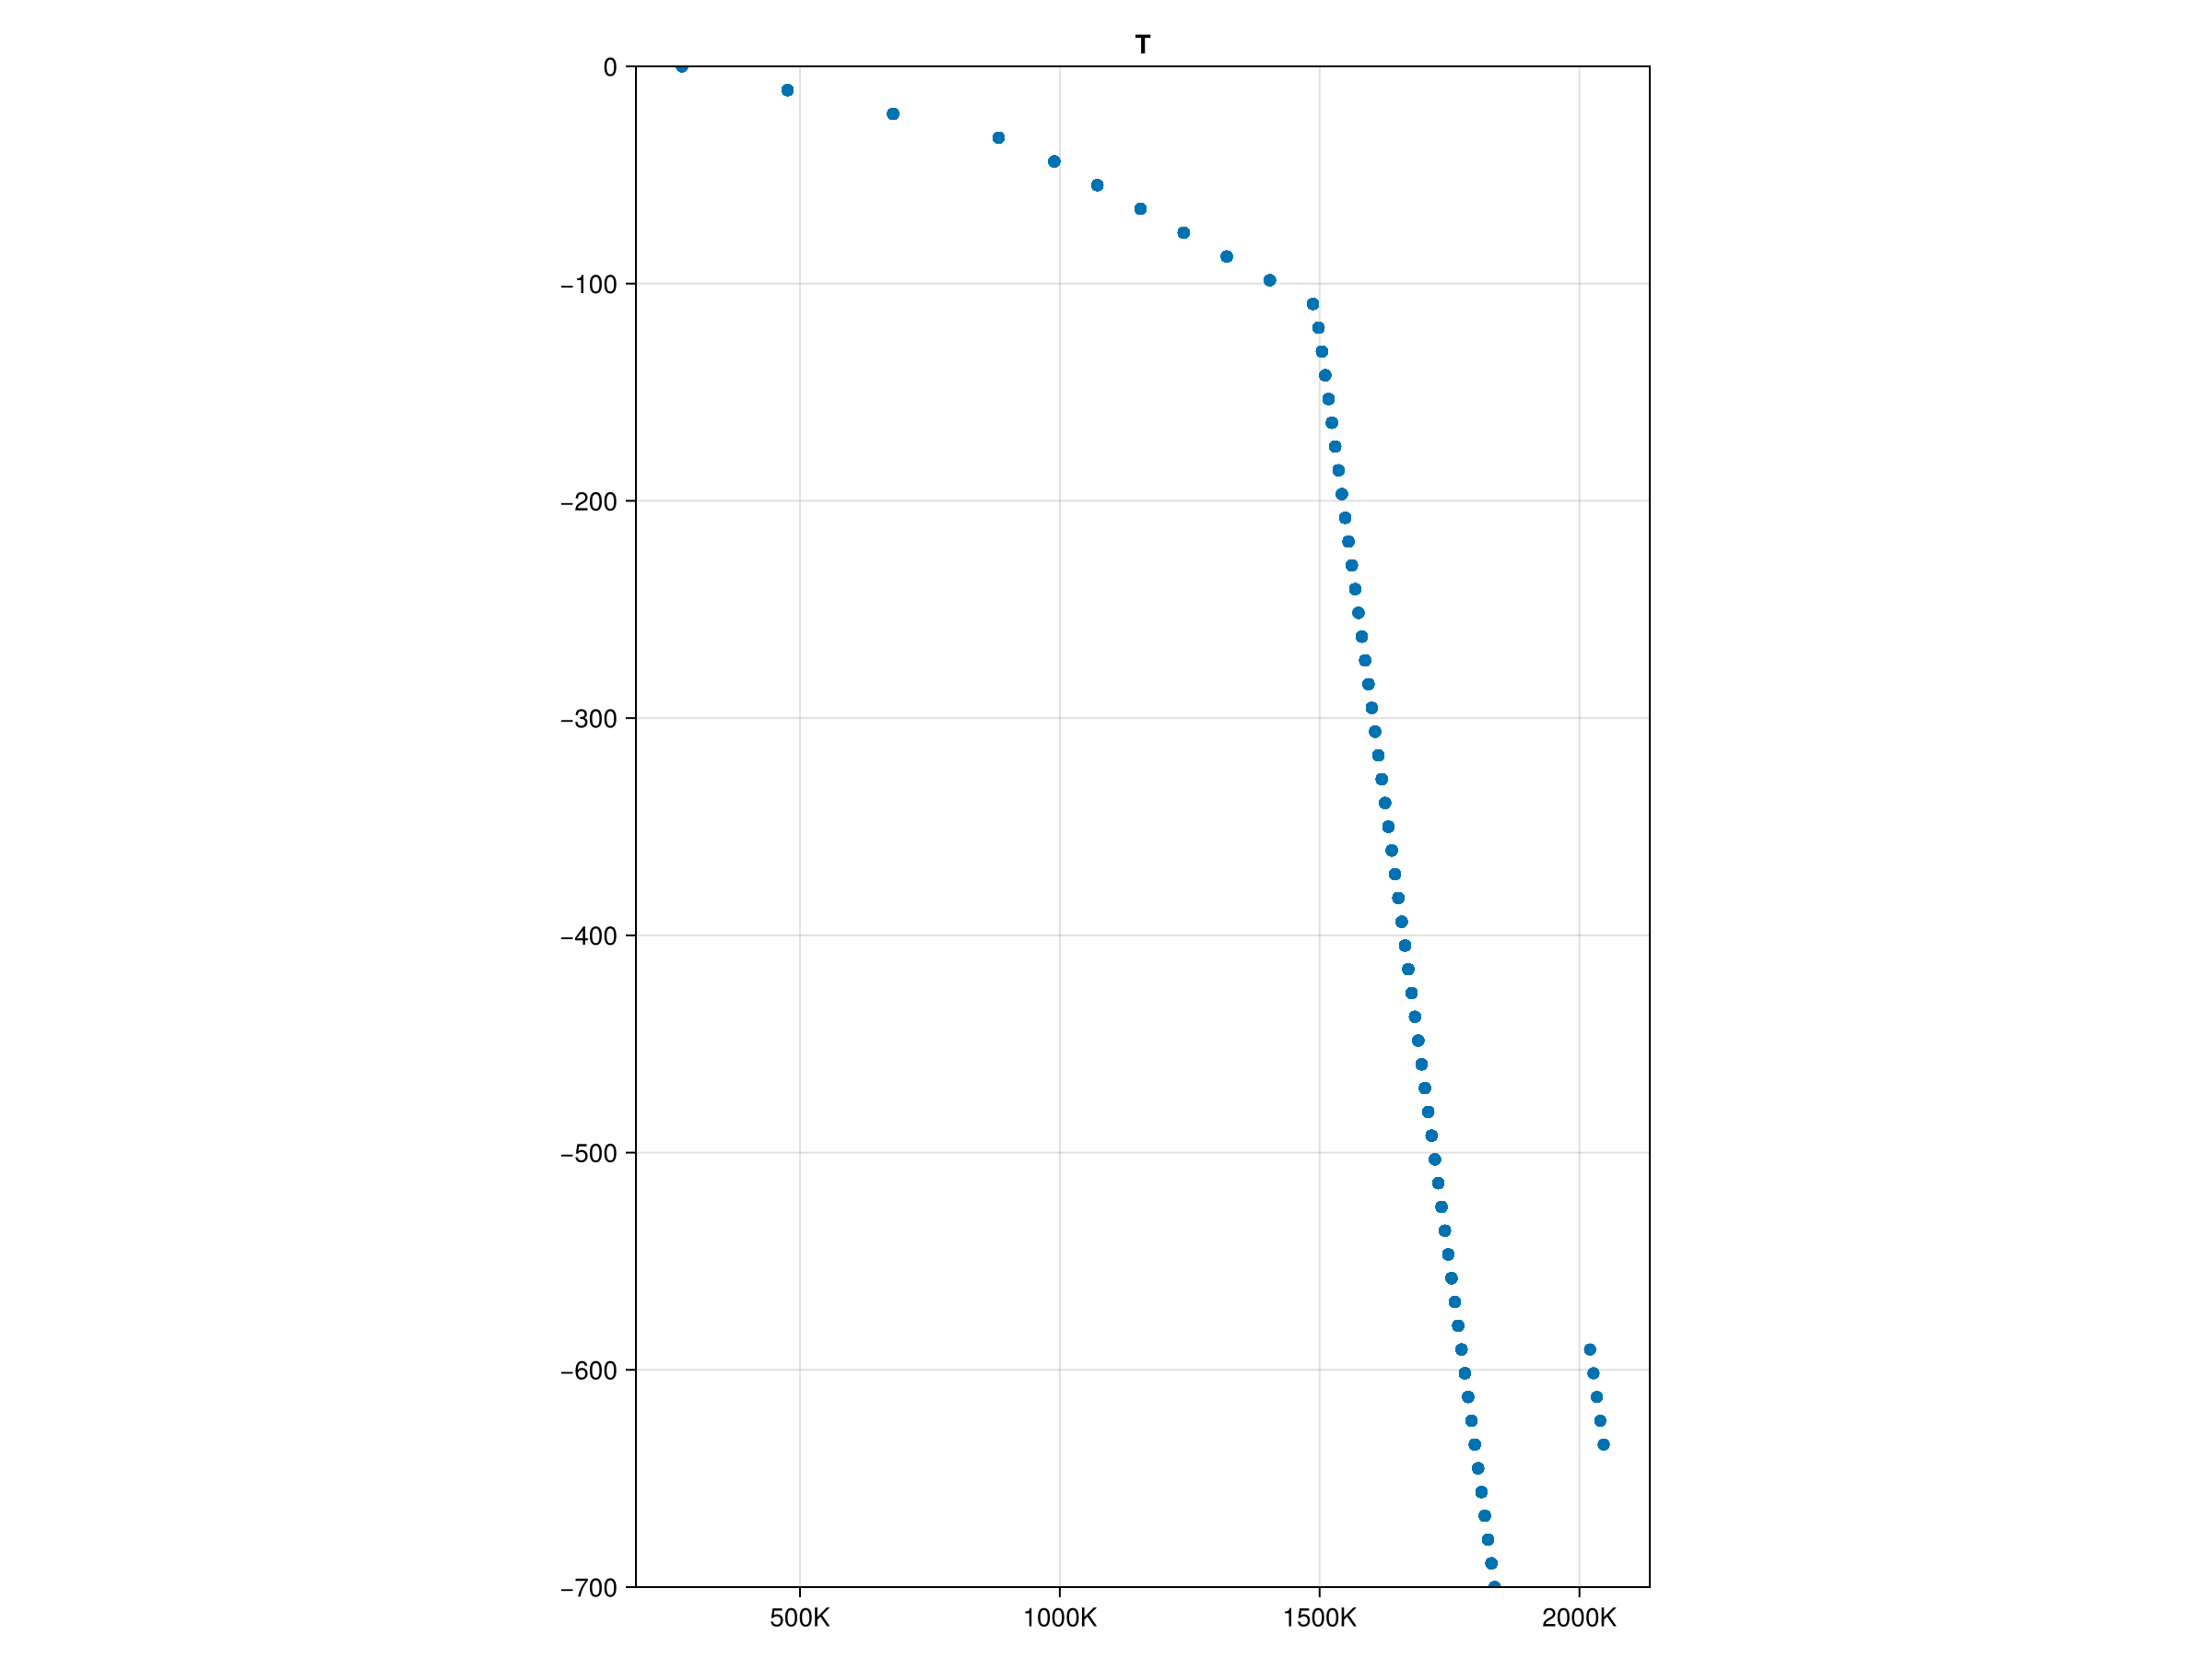

In [16]:
fig = let
    T_dimensional = dimensionalize(thermal.T[2:end-1,:][:], K, CharDim)
    Yv  = [dimensionalize(y, m, CharDim).val /1e3 for x in xvi[1], y in xvi[2]][:]
    fig = Figure(size = (1200, 900))
    ax1 = Axis(fig[1,1], aspect = 2/3, title = "T")
    scatter!(ax1, T_dimensional, Yv)
    ylims!(ax1, minimum(Yv) , 0)
    fig
end

Now we can also initialize the PT coefficients and arrays corresponing to the thermal solver.

In [17]:
args       = (; T = thermal.Tc, P = stokes.P, dt = Inf)
pt_thermal = PTThermalCoeffs(
    backend_JR, rheology, phase_ratios, args, dt, ni, di, li; ϵ=1e-6, CFL= 0.98/ √2.1
)

JustRelax.PTThermalCoeffs{Float64, Matrix{Float64}}(0.6762642481555071, 1.0e-6, 1.0, 1.0, 0.010566628877429799, [0.04599747092499234 0.04603147495175868 … 0.06459964955421894 0.0763483290391219; 0.04599747092499234 0.04603147495175868 … 0.06459964955421894 0.0763483290391219; … ; 0.04599747092499234 0.04603147495175868 … 0.06459964955421894 0.0763483290391219; 0.04599747092499234 0.04603147495175868 … 0.06459964955421896 0.0763483290391219], [0.0017539315535069352 0.0017522170405650983 … 0.0011918925595616437 0.0010005014366491066; 0.0017539315535069352 0.0017522170405650979 … 0.0011918925595616437 0.0010005014366491066; … ; 0.0017539315535069352 0.0017522170405650979 … 0.0011918925595616437 0.0010005014366491066; 0.0017539315535069352 0.0017522170405650979 … 0.0011918925595616442 0.0010005014366491066])

## Buoyancy forces, pressure and viscosity

In [18]:
args = (; T = thermal.Tc, P = stokes.P,  dt=Inf)

# Buoyancy forces
ρg               = @zeros(ni...), @zeros(ni...)
compute_ρg!(ρg[2], phase_ratios, rheology, args)
# Pressure 
stokes.P .= reverse(cumsum(reverse(ρg[2].*di[2]), dims=2) , dims=2)
# Viscosity
viscosity_cutoff = nondimensionalize((1e16Pa*s, 1e24Pa*s), CharDim)
compute_viscosity!(stokes, phase_ratios, args, rheology, viscosity_cutoff)

# Some extra steps before solving the problem...

We need to allocate some buffer arrays to compute the subgrid diffusion step

In [19]:
# helper function
function copyinn_x!(A, B)
    @parallel function f_x(A, B)
        @all(A) = @inn_x(B)
        return nothing
    end
    @parallel f_x(A, B)
end
# thermal buffer arrays without ghost nodes
T_buffer    = @zeros(ni.+1)
Told_buffer = similar(T_buffer)
# diffusive time step array
dt₀         = similar(stokes.P)
# copy inner views of T and T0 on the buffer arrays
for (dst, src) in zip((T_buffer, Told_buffer), (thermal.T, thermal.Told))
    copyinn_x!(dst, src)
end
# interpolate initial thermal field onto the particles
grid2particle!(pT, xvi, T_buffer, particles)

# 6. Advancing one time step

## Solve Stokes problem

In [20]:
# solve stokes
solve!(
    stokes,
    pt_stokes,
    di,
    flow_bcs,
    ρg,
    phase_ratios,
    rheology,
    args,
    Inf,
    igg;
    kwargs = (;
        iterMax          = 150e3,
        nout             = 1e3,
        viscosity_cutoff = viscosity_cutoff
    )
)
# update time step
dt = compute_dt(stokes, di)

Total steps = 1000, err = 1.656e-04 [norm_Rx=1.368e-04, norm_Ry=1.656e-04, norm_∇V=1.904e-06] 
Total steps = 2000, err = 2.113e-05 [norm_Rx=1.064e-05, norm_Ry=2.113e-05, norm_∇V=3.820e-07] 
Total steps = 3000, err = 2.013e-06 [norm_Rx=6.928e-07, norm_Ry=2.013e-06, norm_∇V=2.782e-08] 
Total steps = 4000, err = 1.674e-07 [norm_Rx=4.574e-08, norm_Ry=1.674e-07, norm_∇V=1.933e-09] 
Total steps = 5000, err = 1.349e-08 [norm_Rx=3.099e-09, norm_Ry=1.349e-08, norm_∇V=1.365e-10] 


0.049794212299959895

## Solve thermal problem and do subgrid diffusion on the particles

In [21]:
# thermal solver
heatdiffusion_PT!(
    thermal,
    pt_thermal,
    thermal_bc,
    rheology,
    args,
    dt,
    di;
    kwargs = (
        igg     = igg,
        phase   = phase_ratios,
        iterMax = 10e3,
        nout    = 1e2,
        verbose = true
    ),
)
# subgrid diffusion
for (dst, src) in zip((T_buffer, Told_buffer), (thermal.T, thermal.Told))
    copyinn_x!(dst, src)
end
subgrid_characteristic_time!(
    subgrid_arrays, particles, dt₀, phase_ratios, rheology, thermal, stokes, xci, di
)
centroid2particle!(subgrid_arrays.dt₀, xci, dt₀, particles)
subgrid_diffusion!(
    pT, T_buffer, thermal.ΔT[2:end-1, :], subgrid_arrays, particles, xvi,  di, dt
)



Starting thermal diffusion solver...

iter = 100, err = 1.578e-12 

 ...solver finished in 0.45799 seconds 




## Particles advection

In [22]:
# advect particles in space
advection!(particles, RungeKutta2(), @velocity(stokes), (grid_vx, grid_vy), dt)
# advect particles in memory
move_particles!(particles, xvi, particle_args)
# check if we need to inject particles
inject_particles_phase!(particles, pPhases, (pT, ), (T_buffer,), xvi)
# update phase ratios
phase_ratios_center!(phase_ratios, particles, grid, pPhases)

# Update T on the grid
particle2grid!(T_buffer, pT, xvi, particles)
@views thermal.T[2:end-1, :] .= T_buffer
@views thermal.T[:, end]     .= Ttop
@views thermal.T[:, 1]       .= Tbot
thermal_bcs!(thermal, thermal_bc)
temperature2center!(thermal)

## Visualize the results

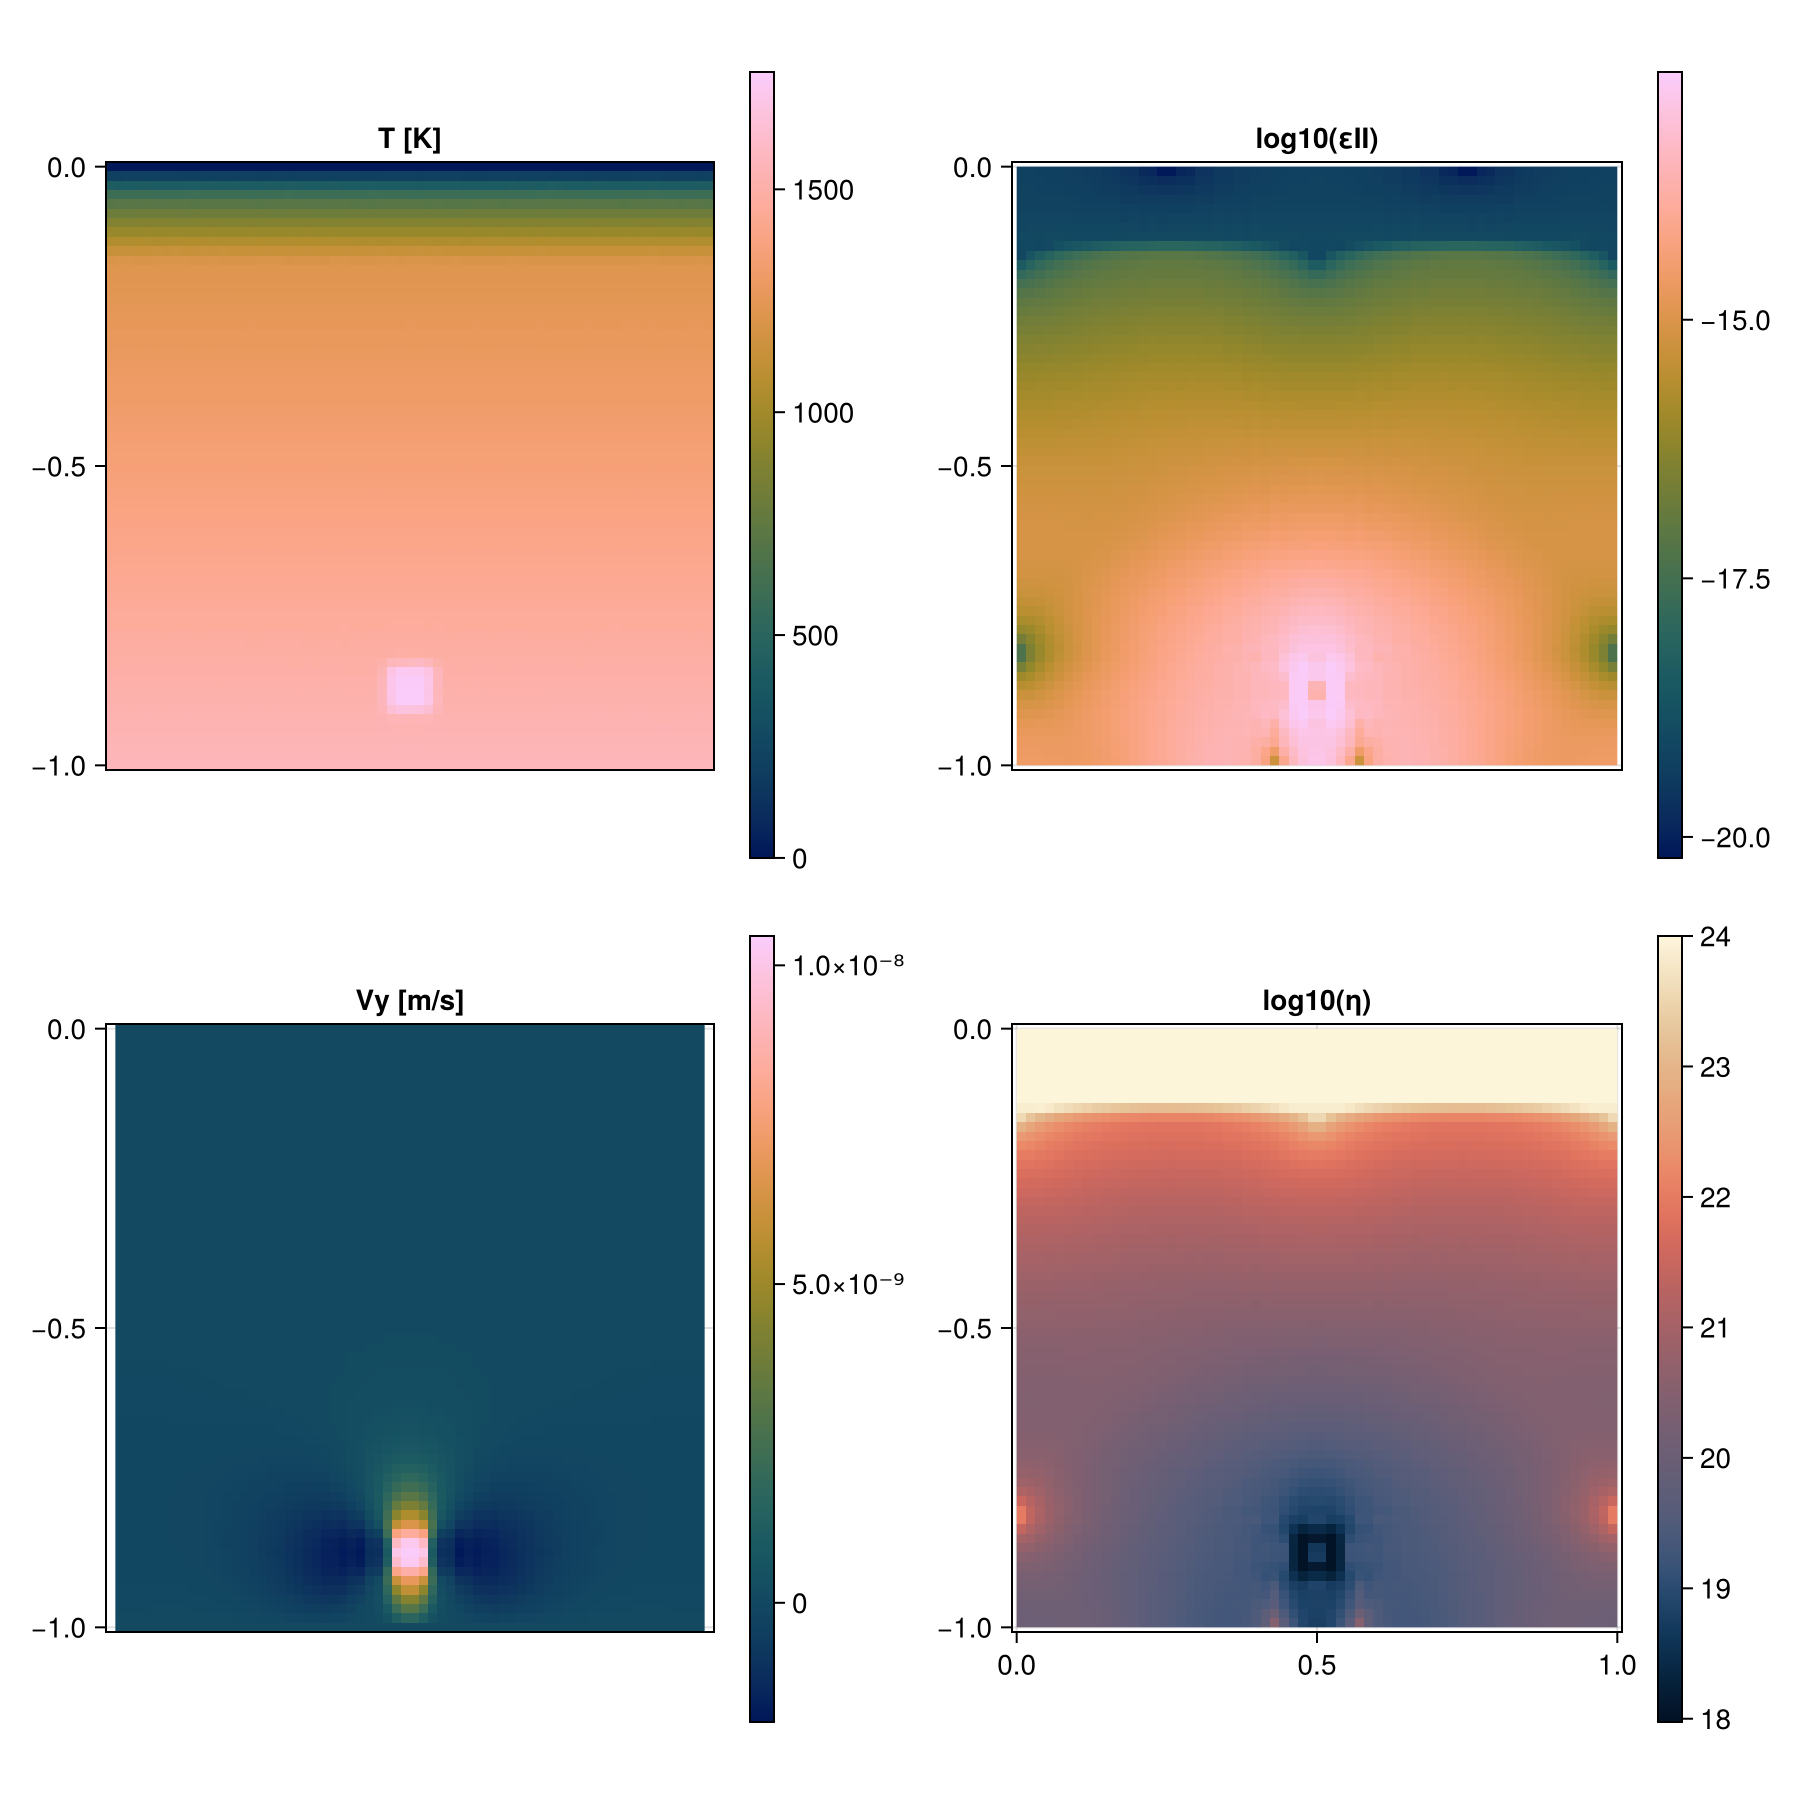

In [23]:
# compute strain rate invariant
tensor_invariant!(stokes.ε)

# Make Makie figure
fig = let
    fig = Figure(size = (900, 900))
    ax1 = Axis(fig[1,1], aspect = ar, title = "T [K]")
    ax2 = Axis(fig[2,1], aspect = ar, title = "Vy [m/s]")
    ax3 = Axis(fig[1,3], aspect = ar, title = "log10(εII)")
    ax4 = Axis(fig[2,3], aspect = ar, title = "log10(η)")
    # Plot temperature
    h1  = heatmap!(ax1, xvi[1], xvi[2], Array(ustrip.(dimensionalize(thermal.T[2:(end - 1), :], C, CharDim))), colormap=:batlow)
    # Plot particles phase
    h2  = heatmap!(ax2, xci[1], xvi[2], Array(ustrip.(dimensionalize(stokes.V.Vy, m/s, CharDim))) , colormap=:batlow)
    # Plot 2nd invariant of strain rate
    h3  = heatmap!(ax3, xci[1], xci[2], Array(log10.(ustrip.(dimensionalize(stokes.ε.II, s^-1,CharDim)))) , colormap=:batlow)
    # Plot effective viscosity
    h4  = heatmap!(ax4, xci[1], xci[2], Array(log10.(ustrip.(dimensionalize(stokes.viscosity.η_vep,Pa*s,CharDim)))) , colormap=:lipari)
    hidexdecorations!(ax1)
    hidexdecorations!(ax2)
    hidexdecorations!(ax3)
    Colorbar(fig[1,2], h1)
    Colorbar(fig[2,2], h2)
    Colorbar(fig[1,4], h3)
    Colorbar(fig[2,4], h4)
    linkaxes!(ax1, ax2, ax3, ax4)
    fig
end